In [68]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
%matplotlib inline

from scipy.stats import probplot

import sys
sys.path.append("../")

from electronfactors.model.utilities import create_model, pull_data, fit_give, estimate_population_uncertainty
from electronfactors.visuals.utilities import create_green_cm

In [69]:
green_cm = create_green_cm()

In [70]:
def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    results = sm.OLS(y, X).fit()
    return results

In [71]:
from matplotlib import rc
rc('font',**{'family':'serif',
             'size':'16'})
rc('text', usetex=True)
rc('legend', fontsize=16, scatterpoints=1, fancybox=True)

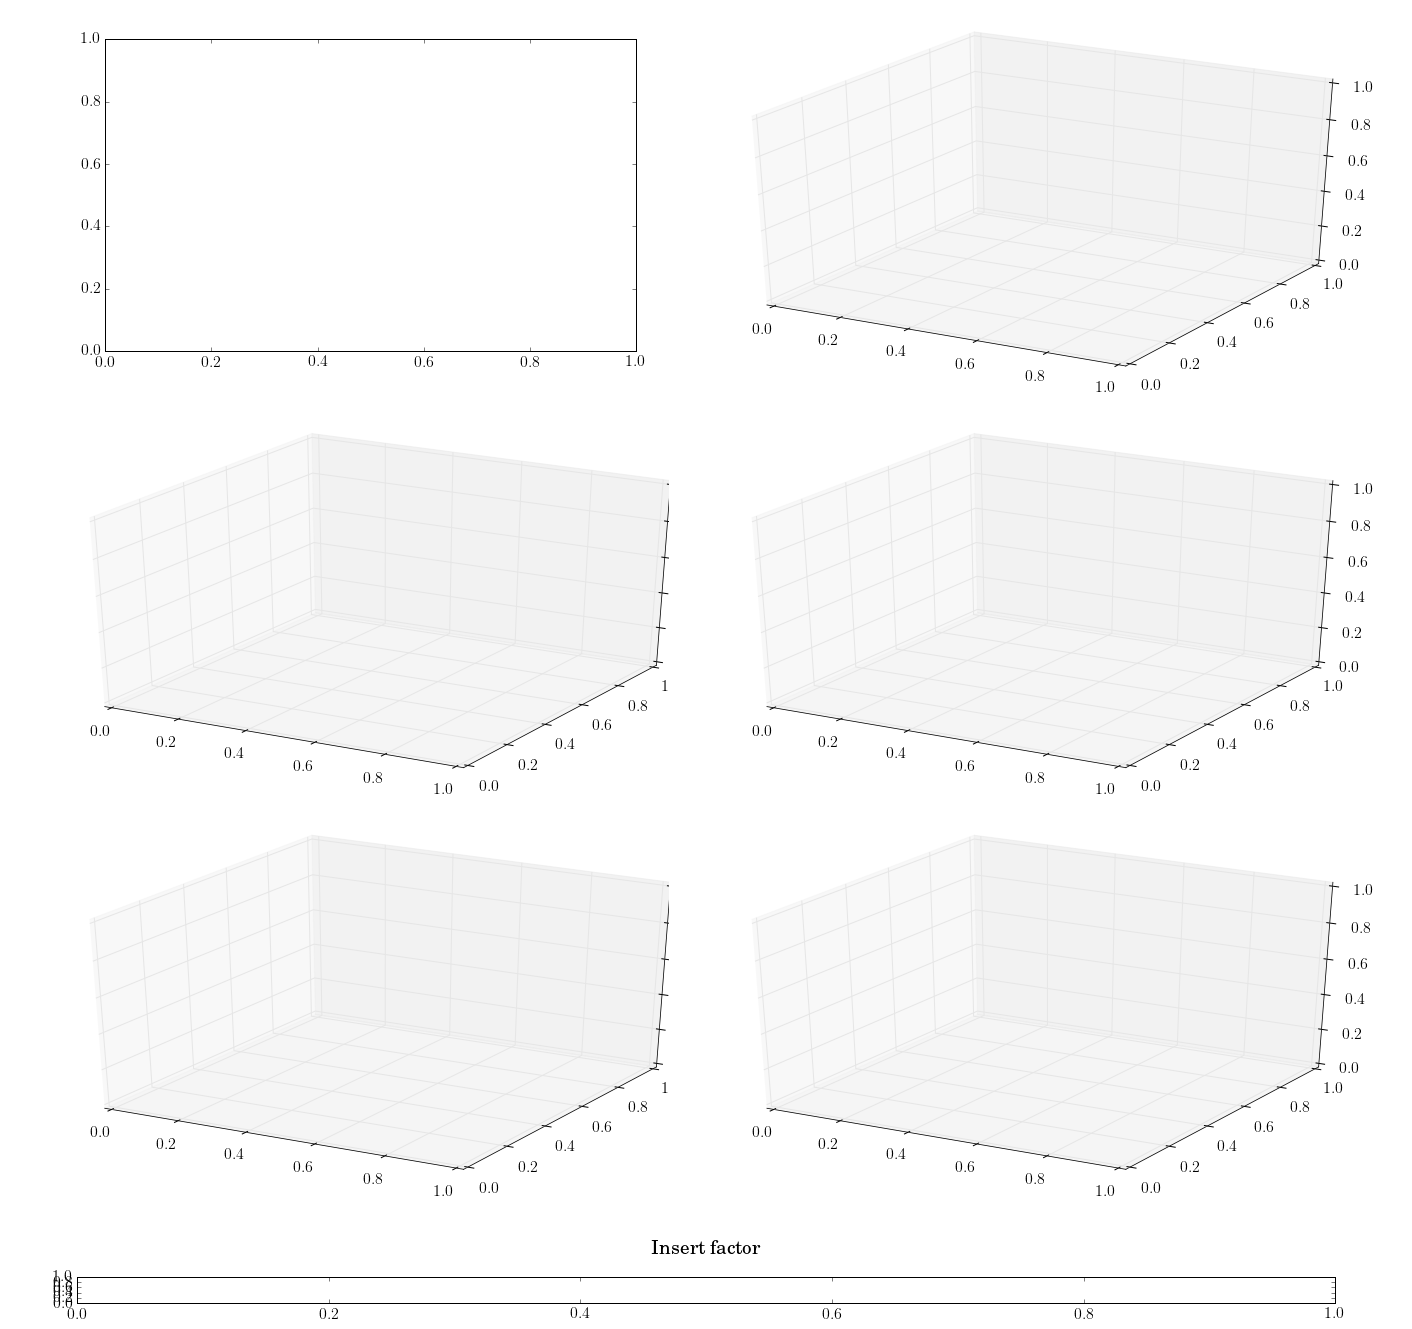

In [72]:
fig = plt.figure(figsize=(6*1.618*2,6*3))

gs1 = gridspec.GridSpec(3, 2)
gs1.update(left=0, right=1, top=1, bottom=0.085, hspace=0.05, wspace=-0.1)

ax1 = fig.add_subplot(gs1[0,1], projection='3d')
ax2 = fig.add_subplot(gs1[1,0], projection='3d')
ax3 = fig.add_subplot(gs1[1,1], projection='3d')
ax4 = fig.add_subplot(gs1[2,0], projection='3d')
ax5 = fig.add_subplot(gs1[2,1], projection='3d')

gs2 = gridspec.GridSpec(3, 2)
gs2.update(left=0.07, right=0.83, top=0.975, bottom=0.23, hspace=0.05, wspace=0)
ax0 = fig.add_subplot(gs2[0,0])


cbar_ax = fig.add_axes([0.05, 0.0, 0.9, 0.02])
cbar_ax.set_title(r'Insert factor', y=1.7)

In [73]:
def display_fit(width, eqPonA, factor, model, fig, ax):
#     y = np.arange(np.floor(np.min(width)) - 0.5, np.ceil(np.max(width)) + 0.5, 0.01)
#     x = np.arange(np.floor(np.min(eqPonA)*10)/10 - 0.2, np.ceil(np.max(eqPonA)*10)/10 + 0.2, 0.002)

    y = np.arange(np.floor(np.min(width)) - 0.5, np.ceil(np.max(width)) + 0.5, 0.05)
    x = np.arange(np.floor(np.min(eqPonA)*10)/10 - 0.2, np.ceil(np.max(eqPonA)*10)/10 + 0.2, 0.01)

    xx, yy = np.meshgrid(x, y)

    zz = model(yy, xx)
    give = fit_give(yy, xx, width, eqPonA, factor, kx=2, ky=1)

    outOfTolerance = (give > 0.5)
    
    valid_only = zz.copy()    
    valid_only[outOfTolerance] = np.nan
    
    print(np.nanmax(valid_only))
    print(np.nanmin(valid_only))

    c = ax.contourf(xx, yy, valid_only, 100, alpha=1, cmap=green_cm, vmin=0.93, vmax=1.01)
    ax.contourf(xx, yy, zz, 100, alpha=1, cmap=green_cm, vmin=0.934, vmax=1.007)
    cb = plt.colorbar(
        c, cax=cbar_ax, ticks=np.arange(0.93, 1.01, 0.005),
        orientation='horizontal')
    
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')
    
    cb.set_clim([0.93, 1.01])
    
#     ax.yaxis.set_ticks_position('right')
#     ax.yaxis.set_label_position('right')

    ax.contour(xx, yy, give, levels=np.linspace(0.498,0.502), colors='k')

    ax.scatter(eqPonA, width, s=200, alpha=0.9, 
                c='black', zorder=3, label=r'Measured data')

    ax.set_ylabel(r'Width (cm)')
    ax.set_xlabel(r'Perimeter / Area (cm$^{-1}$)')

In [74]:
width = np.array([ 3.16,  7.82,  5.34,  7.08,  6.08,  3.55,  5.25,  6.53])
eqPonA = np.array([ 1.02957848,  0.4429889 ,  0.59405193,  0.47320223,  0.63045757,
                    0.8513652 ,  0.76118069,  0.49620497])
factor = np.array([ 0.9348,  1.0019,  0.9934,  1.0052,  0.9933,  0.9443,  0.9705,
                    1.0004])

1.0062377171
0.933667618314


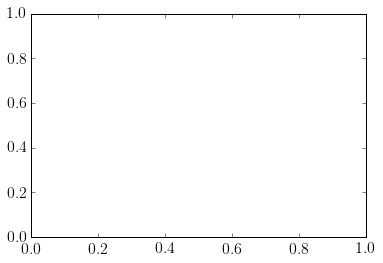

In [75]:
model = create_model(width, eqPonA, factor)

display_fit(width, eqPonA, factor, model, fig, ax0)


In [76]:
ax0.set_title(r'Comparison of deformability between two sampled points')
# ax0.scatter(4.5, 0.78, marker='s', lw=2,
#             s=300, alpha=0.7, c='red', 
#             label=r'Deformability = 0.6 (not valid for prediction)')
# ax0.scatter(6, 0.55, marker='^', lw=2,
#             s=340, alpha=0.7, c='green', 
#             label=r'Deformability = 0.3 (valid for prediction)')
# ax0.plot(3, 0.4, 'k-', label=r'Deformability bound')

ax0.scatter(0.78, 4.5, marker='s', lw=2,
            s=300, alpha=0.7, c='red', 
            label=r'Deformability = 0.6 (invalid)')
ax0.scatter(0.55, 6,  marker='^', lw=2,
            s=340, alpha=0.7, c='green', 
            label=r'Deformability = 0.3 (valid)')
ax0.plot(0.4, 3,'k-', lw=2, label=r'Deformability bound')


legend = ax0.legend(fancybox=True, loc='upper left')
legend.get_frame().set_facecolor([1,1,1,0.8])

ax0.invert_xaxis()

xlim = [3, 8]
ylim = [0.4, 1.1]

ax0.set_xlim([1.1, 0.4])
ax0.set_ylim([3, 8])

# fig

(3, 8)

In [77]:
def display_fit_3D(width, eqPonA, factor, model, fig, ax, give_level=None, high_res=False):    
#     x = np.arange(xlim[0], xlim[1], 0.005)
#     y = np.arange(ylim[0], ylim[1], 0.001)

    if high_res:
        x = np.arange(xlim[0], xlim[1], 0.01)
        y = np.arange(ylim[0], ylim[1], 0.001)
    else:
        x = np.arange(xlim[0], xlim[1], 0.02)
        y = np.arange(ylim[0], ylim[1], 0.002)

    xx, yy = np.meshgrid(x, y)

    zz = model(xx, yy)
    
#     if give_level is not None:
#         give = fit_give(xx, yy, width, eqPonA, factor, kx=2, ky=1)
#         give = give + give_level - 0.5 
#         ax.contour(xx, yy, give, levels=np.linspace(0.498,0.502) + give_level - 0.5, colors='k')
    
    
    small = (zz < 0)
    zz[small] = 0
    
    
    ax.plot_surface(xx, yy, zz, rstride=10, cstride=10, alpha=1,
                    cmap=green_cm, lw=0.2, vmin=0.934, vmax=1.007)
    
    ax.scatter(width, eqPonA, factor, s=200, alpha=1, c='black', zorder=10)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim([0,2.5])

    ax.set_xlabel(r'Width (cm)')
    ax.set_ylabel(r'Perimeter / Area (cm$^{-1}$)')
    ax.zaxis.set_rotate_label(False)
    ax.set_zlabel(r'Insert factor', rotation=92.5)

In [78]:
azim = 190

display_fit_3D(width, eqPonA, factor, model, fig, ax1, give_level=0.92)

# ax1.scatter(width, eqPonA, factor, s=200, alpha=0.9, c='black', zorder=10)

ax1.view_init(elev=20, azim=azim)
ax1.set_zlim([0.92,1.03])

# fig

(0.92, 1.03)

In [79]:
pointA = model(4.5, 0.78)
pointB = model(6, 0.55)

In [80]:
display_fit_3D(width, eqPonA, factor, model, fig, ax2, give_level=0)
ax2.set_title(r'Before extreme point included')
ax2.scatter(
    4.5, 0.78, pointA + 1, 
    marker='s', s=300, alpha=0.7, c='red',
    lw=2
)

ax2.plot([4.5]*2, [0.75, 0.81], [pointA]*2, color='darkred', lw=2, alpha=1)
ax2.plot([4.1, 4.9], [0.78]*2, [pointA]*2, color='darkred', lw=2, alpha=1)

ax2.plot([4.5]*2, [0.75, 0.81], [pointA+1]*2, color='darkred', lw=2, alpha=1)
ax2.plot([4.1, 4.9], [0.78]*2, [pointA+1]*2, color='darkred', lw=2, alpha=1)

ax2.plot([4.5]*2, [0.78]*2, [pointA, pointA + 1], lw=2, color='darkred', ls='--', alpha=1)





ax2.view_init(elev=20, azim=azim)

# fig

In [81]:
extreme_modelA = create_model(np.append(width, 4.5), np.append(eqPonA, 0.78), np.append(factor, pointA+1))
display_fit_3D(width, eqPonA, factor, extreme_modelA, fig, ax3, high_res=True)

ax3.plot([4.5]*2, [0.78]*2, [pointA, pointA + 1], lw=2, color='darkred', ls='--', alpha=1)

ax3.set_title(r'After extreme point included')
ax3.plot([4.5]*2, [0.75, 0.81], [extreme_modelA(4.5, 0.78)]*2, color='darkred', lw=2, alpha=1)
ax3.plot([4.1, 4.9], [0.78]*2, [extreme_modelA(4.5, 0.78)]*2, color='darkred', lw=2, alpha=1)

ax3.plot([4.5]*2, [0.75, 0.81], [pointA]*2, color='darkred', lw=2, alpha=1)
ax3.plot([4.1, 4.9], [0.78]*2, [pointA]*2, color='darkred', lw=2, alpha=1)

ax3.plot([4.5]*2, [0.75, 0.81], [pointA+1]*2, color='darkred', lw=2, alpha=1)
ax3.plot([4.1, 4.9], [0.78]*2, [pointA+1]*2, color='darkred', lw=2, alpha=1)

ax3.scatter(4.5, 0.78, pointA + 1, marker='s', s=300, alpha=0.7, c='red', lw=2)

ax3.view_init(elev=20, azim=azim)

extreme_modelA(4.5, 0.78) - pointA

0.6022515186310633

In [82]:
display_fit_3D(width, eqPonA, factor, model, fig, ax4, give_level=0)

ax4.set_title(r'Before extreme point included')
ax4.scatter(6, 0.55, pointB + 1, marker='^', s=340, alpha=0.7, c='green', lw=2)

ax4.plot([6]*2, [0.52, 0.58], [pointB]*2, color='darkgreen', lw=2, alpha=1)
ax4.plot([5.6, 6.4], [0.55]*2, [pointB]*2, color='darkgreen', lw=2, alpha=1)

ax4.plot([6]*2, [0.52, 0.58], [pointB+1]*2, color='darkgreen', lw=2, alpha=1)
ax4.plot([5.6, 6.4], [0.55]*2, [pointB+1]*2, color='darkgreen', lw=2, alpha=1)

ax4.plot([6]*2, [0.55]*2, [pointB, pointB + 1], lw=2, color='darkgreen', ls='--', alpha=1)
ax4.view_init(elev=20, azim=azim)

# fig

# plt.savefig('figures/deformability_example_4.png', bbox_inches='tight', dpi=300)

In [83]:
extreme_modelB = create_model(np.append(width, 6), np.append(eqPonA, 0.55), np.append(factor, pointB+1))

display_fit_3D(width, eqPonA, factor, extreme_modelB, fig, ax5)

ax5.set_title(r'After extreme point included')
ax5.scatter(6, 0.55, pointB + 1, marker='^', s=340, alpha=0.7, c='green', lw=2)
ax5.plot([6]*2, [0.55]*2, [pointB, pointB + 1], lw=2, color='darkgreen', ls='--', alpha=1)

ax5.plot([6]*2, [0.52, 0.58], [extreme_modelB(6, 0.55)]*2, color='darkgreen', lw=2, alpha=1)
ax5.plot([5.6, 6.4], [0.55]*2, [extreme_modelB(6, 0.55)]*2, color='darkgreen', lw=2, alpha=1)

ax5.plot([6]*2, [0.52, 0.58], [pointB]*2, color='darkgreen', lw=2, alpha=1)
ax5.plot([5.6, 6.4], [0.55]*2, [pointB]*2, color='darkgreen', lw=2, alpha=1)

ax5.plot([6]*2, [0.52, 0.58], [pointB+1]*2, color='darkgreen', lw=2, alpha=1)
ax5.plot([5.6, 6.4], [0.55]*2, [pointB+1]*2, color='darkgreen', lw=2, alpha=1)
ax5.view_init(elev=20, azim=azim)

extreme_modelB(6, 0.55) - pointB

0.28218384691447562

In [84]:
ax1.plot([6]*2, [0.52, 0.58], [pointB]*2, color='darkgreen', lw=2, alpha=1)
ax1.plot([5.6, 6.4], [0.55]*2, [pointB]*2, color='darkgreen', lw=2, alpha=1)

ax1.plot([6]*2, [0.55]*2, [pointB, 1.03], lw=2, color='darkgreen', ls='--', alpha=1)


ax1.plot([4.5]*2, [0.78]*2, [pointA, 1.03], lw=2, color='darkred', ls='--', alpha=1)

ax1.plot([4.5]*2, [0.75, 0.81], [pointA]*2, color='darkred', lw=2, alpha=1)
ax1.plot([4.1, 4.9], [0.78]*2, [pointA]*2, color='darkred', lw=2, alpha=1)


ax1.set_title("Standard bivariate spline fit")

# fig

In [85]:
fig.savefig('figures/deformability_example.png', bbox_inches='tight', dpi=300)

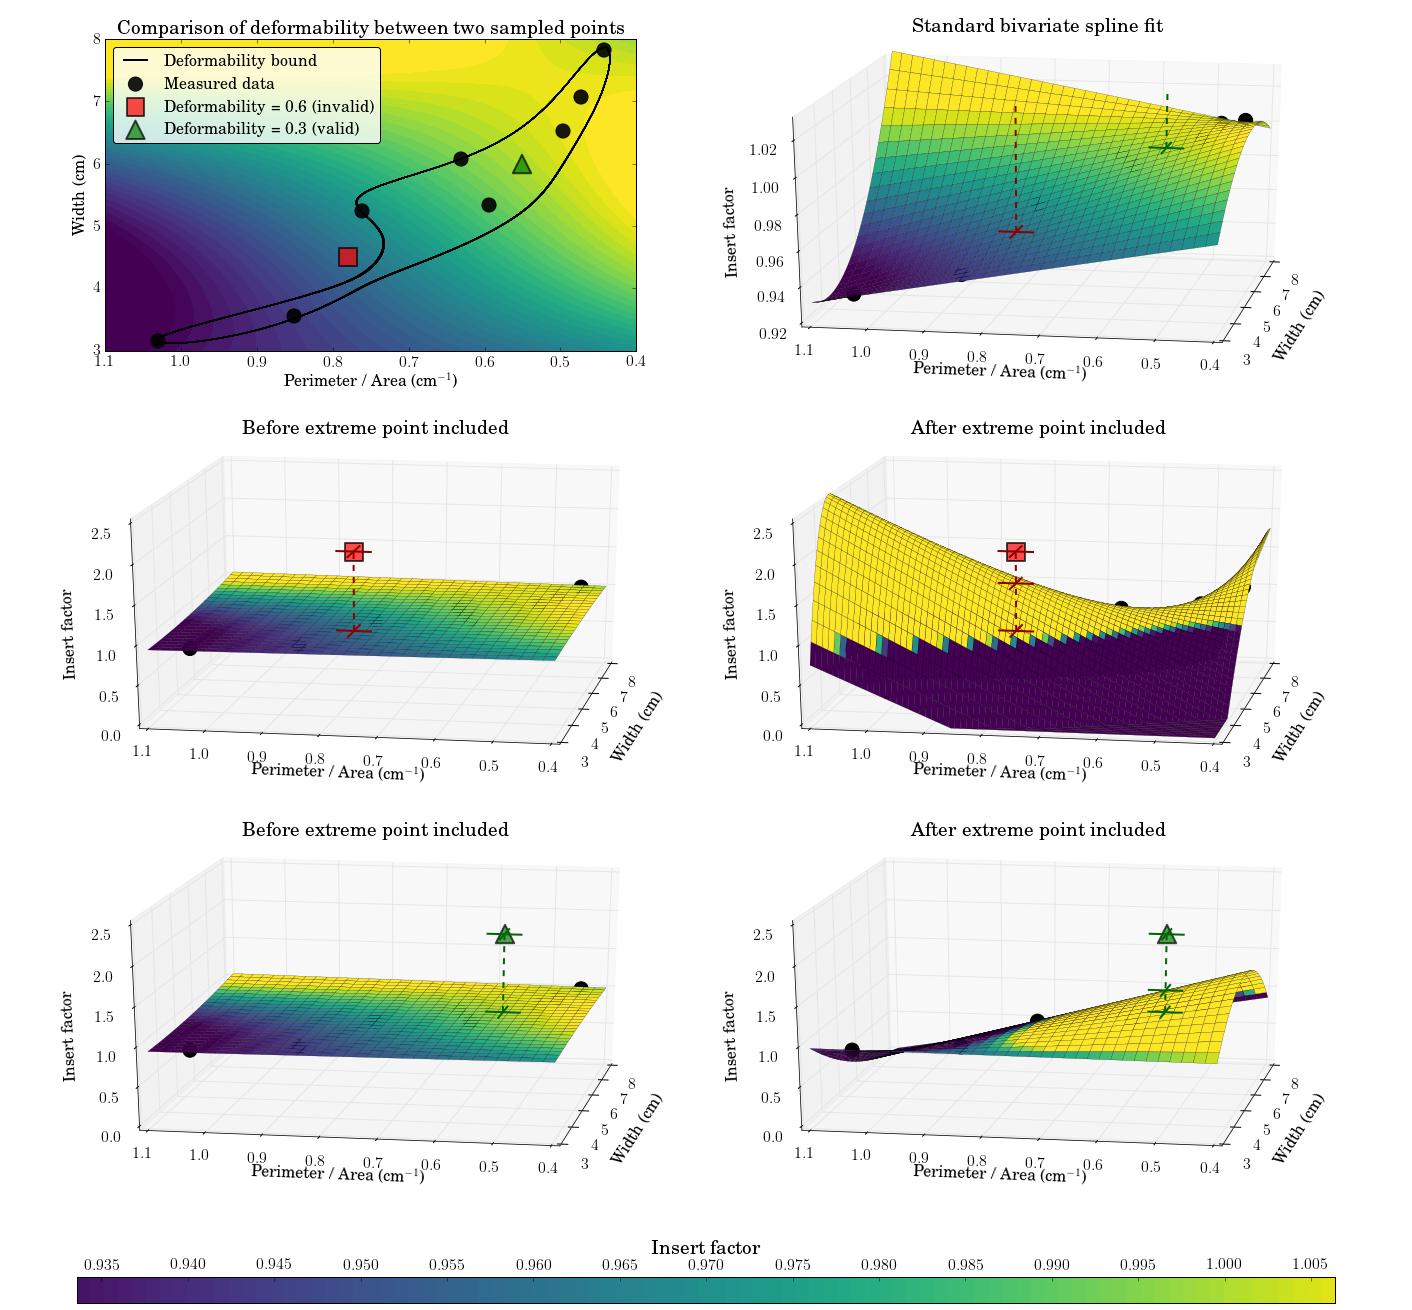

In [86]:
fig